# TRAINING THE MODEL

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initializing the dataset

In [2]:
data = pd.read_csv('./dataset/fer2013.csv')
data.shape

(35887, 3)

### Pre-Process the dataset

In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [5]:
emotion_map = {
    0: ' Angry',
    1: 'Digust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprised', 
    6: 'Neutral'
}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


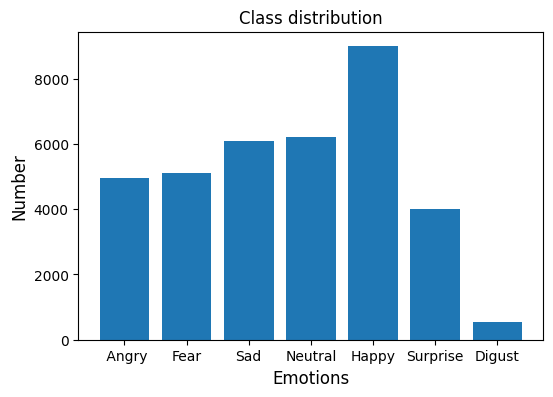

In [6]:

plt.figure(figsize=(6, 4))
plt.bar(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Number', fontsize=12)
plt.show()

### Read the dataset file, Extract pixels, Normalize them

In [8]:
x = []
y = []
first = True

for line in open("./dataset/fer2013.csv"):
    if first:
        first = False
    else:
        row = line.split(',')
        x.append([int(p) for p in row[1].split()])
        y.append(int(row[0]))

x, y = np.array(x) / 255.0, np.array(y)

### Convert the linear dataset to 48x48 array of pixels

In [9]:
x = x.reshape(-1, 48, 48, 1)

### Split the training and testing sets

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.1, 
    random_state=0
)

In [11]:
num_class = len(set(y))
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

### Augment the images and generate batches of image data

In [12]:
datagen = ImageDataGenerator(
    zoom_range=0.15,
    height_shift_range=0.15,
    width_shift_range=0.15,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(x_train)

### Sequential CNN Model

In [14]:
Input_shape = (48, 48, 1)

cnn_model = Sequential()
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same', input_shape=Input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'elu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.4))

cnn_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2, 2))
cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())

cnn_model.add(Dense(units=1024, activation='relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(units=512, activation='relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(units=7, activation='softmax'))


# Compile model and check for formatting errors, define the
# loss function, the optimizer, learning rate, and the
# metrics (accuracy).
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(
        lr=0.001,
        beta_1=0.9,
        beta_2=0.999
    ), 
    metrics = ['accuracy']
)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                      

c:\Users\Prerak\Desktop\Padhai\UNIV_STUFF\AML\AML_project_CLA4\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Training the model

In [15]:
history = cnn_model.fit(
    datagen.flow(
        x_train, y_train,
        batch_size=64
    ),
    epochs=350, 
    validation_data=(x_test, y_test), 
    verbose=1
)

Epoch 1/350
505/505 [==============================] - 36s 43ms/step - loss: 1.9144 - accuracy: 0.2296 - val_loss: 1.8198 - val_accuracy: 0.2650
Epoch 2/350
505/505 [==============================] - 20s 40ms/step - loss: 1.7633 - accuracy: 0.2771 - val_loss: 1.6285 - val_accuracy: 0.3533
Epoch 3/350
505/505 [==============================] - 20s 40ms/step - loss: 1.6781 - accuracy: 0.3301 - val_loss: 1.9572 - val_accuracy: 0.2756
Epoch 4/350
505/505 [==============================] - 21s 41ms/step - loss: 1.5820 - accuracy: 0.3820 - val_loss: 1.4129 - val_accuracy: 0.4678
Epoch 5/350
505/505 [==============================] - 21s 41ms/step - loss: 1.5008 - accuracy: 0.4175 - val_loss: 1.4262 - val_accuracy: 0.4433
Epoch 6/350
505/505 [==============================] - 21s 41ms/step - loss: 1.4302 - accuracy: 0.4487 - val_loss: 1.3153 - val_accuracy: 0.4962
Epoch 7/350
505/505 [==============================] - 20s 40ms/step - loss: 1.3589 - accuracy: 0.4788 - val_loss: 1.3189 - val_ac

### Evaluate the model (loss, accuracy)

In [23]:
score = cnn_model.evaluate(x_test, y_test)
score

113/113 [==============================] - 1s 8ms/step - loss: 0.8850 - accuracy: 0.6952


[0.8849554657936096, 0.6951797008514404]

### Training and Validation metrics vs Epoch Plots

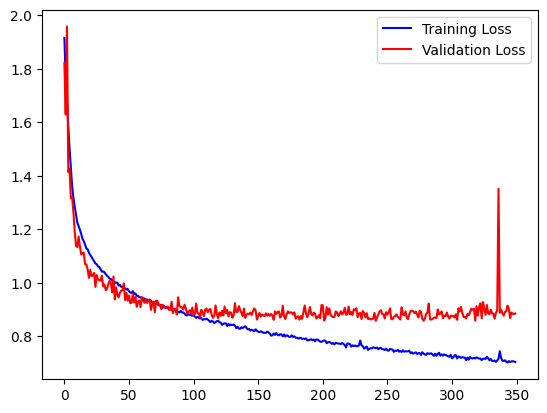

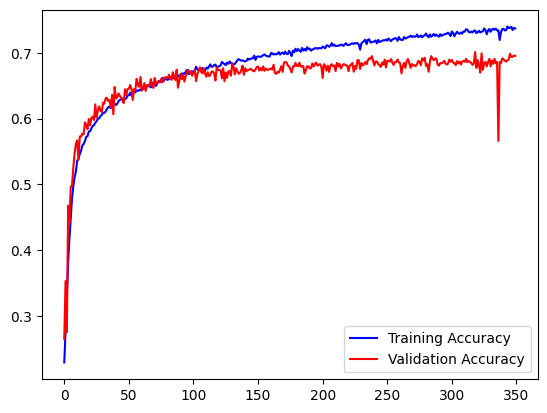

In [27]:
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

### Save model weights and embeddings

In [18]:
import datetime

cnn_model.save('./weights/emotion-vgg19-{timestamp}.h5'
    .format(timestamp=datetime.datetime.now().strftime("%d%m%Y_%H%M%S"))
)

# RUN THE MODEL

### Import libraries

In [19]:
import cv2
import numpy as np
from keras.models import load_model

### Load the trained model and Haarcascade face detector

In [20]:
model = load_model('./weights/emotion-vgg19-16042024_215317.h5')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

### Detect emotions from the cam feed

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face_roi = gray[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (48, 48))
        face_roi = face_roi / 255.0
        face_roi = np.reshape(face_roi, (1, 48, 48, 1))
    
        predicted_class = np.argmax(model.predict(face_roi), axis=-1)
        emotion = emotion_map[predicted_class[0]]
    
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()